In [1]:
import os
import sys

from pathlib import Path

import numpy as np
import pandas as pd

import math
from math import exp
import scipy.integrate as intg
import scipy.interpolate as inp

from scipy import optimize
from sklearn import linear_model

import matplotlib.pyplot as plt

from CoolProp.HumidAirProp import HAPropsSI
import CoolProp.CoolProp as CP
import psychrolib as psylib
psylib.SetUnitSystem(psylib.SI)

In [2]:
sys.path.insert(0, os.path.join('.','..', '..', 'calibration'))
from thermodynamics import *
# import thermodynamics

# import code of medium model
import media_model_mgcl2 as model_mg
import media_model_water as model_w

# read data

In [148]:
bib_path = os.path.join(os.path.expanduser("~"),"GIT","EnBA_M","BrineGrid_HDisNet")
model_name_teststand =  "Okt_1_teststand" #"Okt_3_test" #
model_name_dempav = "Okt_1_dempav"
output_path_teststand = os.path.join(bib_path, 'modelica_results', model_name_teststand)
output_path_dempav = os.path.join(bib_path, 'modelica_results', model_name_dempav)

In [132]:
df_dempav = pd.read_csv(filepath_or_buffer=output_path_dempav+'\\final_output.csv', index_col=0)

In [149]:
df_teststand = pd.read_csv(filepath_or_buffer=output_path_teststand+'\\final_output.csv', index_col=0)

# analysis with self defined formula

In [155]:
def plot_compare_two_parameters(df, parameter_1, parameter_2, if_save = None):
    
    df_plot = df.copy()
    df_plot = df.sort_values(by=parameter_1).reset_index()
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax2 = ax.twinx()

    ax.scatter(df_plot.index, df_plot[parameter_1], marker = "o", s=100, color = 'red', label = parameter_1)
    # ax.plot(df_Li_reg.T_d_in-273, color = 'red',linewidth=5, linestyle = '--', label = 'Chen_2016_T_des')

    ax2.scatter(df_plot.index, df_plot[parameter_2], marker="*", s=100, color = 'blue', label = parameter_2)
    # ax.plot(df_Mg_reg.reset_index().T_d_in-273, color = 'blue', linewidth=5, linestyle = '--', label = 'MgCl2_T_des')

    # ax.plot(df_Li_reg.Nu, color = 'red', linestyle = ':', label = 'Nu_Chen_2016')
    # ax.plot(df_Mg_reg.reset_index().Nu, color = 'blue', linestyle = ':', label = 'Nu_MgCl2')
    
    ax.set_title('Relation of {} and {}'.format(parameter_1, parameter_2), size = 25, pad = 15)
    
    ax.set_xlabel("experiment sets", size = 25, labelpad = 10)
    ax.set_ylabel(parameter_1, size = 25, labelpad = 10)
    ax2.set_ylabel(parameter_2, size = 25, labelpad = 10)

    ax.tick_params(axis="y", labelsize=25)
    ax2.tick_params(axis="y", labelsize=25)
    
    ax.tick_params(axis="x", labelsize=25)

    plt.xticks(df_plot.index, [str(i) for i in df_plot["index"]])

    ax.legend(loc="upper left", fontsize = 20)
    ax2.legend(loc="lower right", fontsize = 20)
    
    if if_save is not None:
        plt.savefig(if_save, dpi=300)
    
    return

## Analyse DemPav

In [146]:
df_dempav.head()

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,w_air_in,...,Re,Pr,Sc,epsilon_w,epsilon_T,epsilon_h,delta_T,delta_x,delta_T*m_d/m_a,delta_x*m_d/m_a
24,301.14,38.89,0.038312,286.07,0.290551,0.048607,291.11,52.58,281.292,0.009139,...,808.916920,0.716243,0.616794,0.562358,0.665561,0.623625,15.07,0.004337,19.119491,0.005502
13,289.59,89.74,0.044219,293.08,0.276697,0.104691,292.37,60.66,292.745,0.010455,...,962.852685,0.719096,0.614879,0.901198,0.796562,1.067474,-3.49,0.002293,-8.262832,0.005430
5,301.71,43.11,0.050290,292.12,0.318252,0.102675,297.38,40.59,289.957,0.010494,...,1060.984115,0.717570,0.616967,0.657975,0.451512,0.562321,9.59,0.004379,19.579696,0.008940
2,298.02,46.07,0.032644,284.16,0.318572,0.102670,287.98,50.83,281.766,0.009005,...,694.763827,0.716494,0.616260,0.686702,0.724387,0.706884,13.86,0.005408,43.591277,0.017009
10,290.56,73.96,0.046145,288.03,0.276610,0.104692,289.51,60.06,286.984,0.009144,...,1001.603842,0.717612,0.614949,0.681545,0.415020,0.618465,2.53,0.003266,5.739983,0.007410


In [135]:
df_dempav['delta_T'] = df_dempav.T_a_in - df_dempav.T_d_in
df_dempav["delta_x"] = df_dempav.x_a_in - df_dempav.x_d_in_equ

In [136]:
df_dempav['delta_T*m_d/m_a'] = df_dempav.delta_T * df_dempav.m_d_in / df_dempav.m_a_in

In [137]:
df_dempav["delta_x*m_d/m_a"] = df_dempav.delta_x * df_dempav.m_d_in / df_dempav.m_a_in

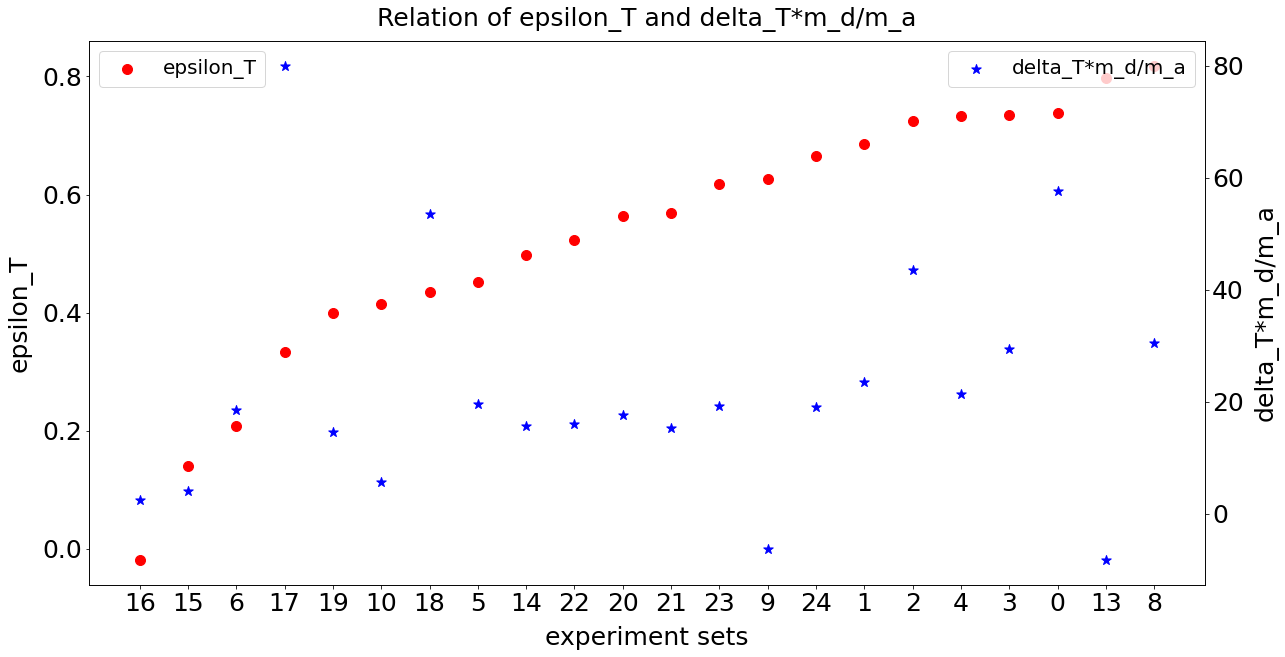

In [115]:
plot_compare_two_parameters(df=df_dempav, \
                            parameter_2='delta_T*m_d/m_a', \
                            parameter_1="epsilon_T", if_save="T_dempav.png")

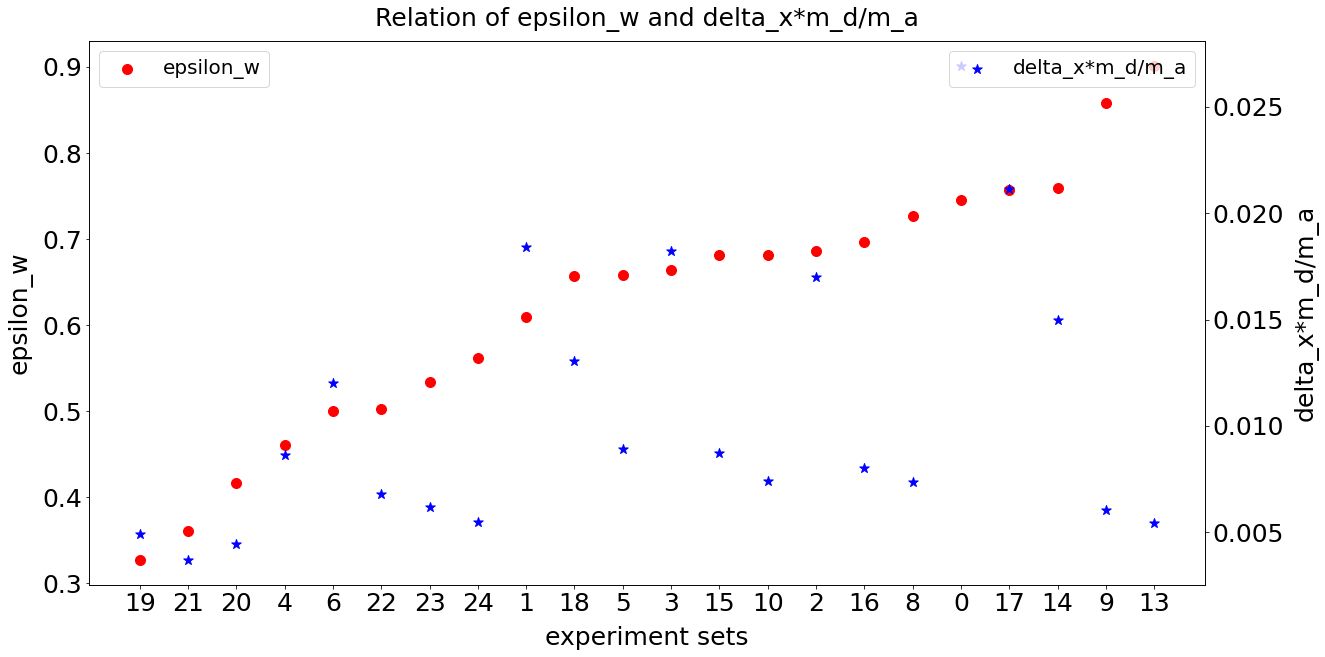

In [117]:
plot_compare_two_parameters(df=df_dempav, \
                            parameter_2='delta_x*m_d/m_a', \
                            parameter_1="epsilon_w", if_save="w_dempav.png")

In [73]:
df_dempav.loc[[9,13,2,0],["xi_d_in","x_a_in","m_a_in","m_d_in","delta_T", "epsilon_T", 'T_a_in', 'T_a_o_exp', 'T_d_in']]

,xi_d_in,x_a_in,m_a_in,m_d_in,delta_T,epsilon_T,T_a_in,T_a_o_exp,T_d_in
9,0.318444,0.010821,0.037419,0.102671,-2.30,0.626087,295.22,296.66,297.52
13,0.276697,0.010475,0.044219,0.104691,-3.49,0.796562,289.59,292.37,293.08
2,0.318572,0.009022,0.032644,0.102670,13.86,0.724387,298.02,287.98,284.16
0,0.318302,0.009457,0.018848,0.102670,10.58,0.738185,298.02,290.21,287.44


In [80]:
df_dempav.loc[[6,17,10,2,0,16,15, 24, 1],["xi_d_in","x_a_in","m_a_in","m_d_in","delta_T", "epsilon_T", 'T_a_in', 'T_a_o_exp', 'T_d_in']]

,xi_d_in,x_a_in,m_a_in,m_d_in,delta_T,epsilon_T,T_a_in,T_a_o_exp,T_d_in
6,0.318283,0.012498,0.050221,0.102676,9.07,0.207277,302.39,300.51,293.32
17,0.277934,0.006337,0.018728,0.104689,14.30,0.332867,290.31,285.55,276.01
10,0.276610,0.009162,0.046145,0.104692,2.53,0.415020,290.56,289.51,288.03
2,0.318572,0.009022,0.032644,0.102670,13.86,0.724387,298.02,287.98,284.16
0,0.318302,0.009457,0.018848,0.102670,10.58,0.738185,298.02,290.21,287.44
16,0.276599,0.008984,0.044718,0.104690,1.05,-0.019048,288.20,288.22,287.15
15,0.276611,0.009138,0.044734,0.104690,1.71,0.140351,288.46,288.22,286.75
24,0.290551,0.009156,0.038312,0.048607,15.07,0.665561,301.14,291.11,286.07
1,0.318186,0.012683,0.036283,0.102670,8.31,0.685921,300.51,294.81,292.20


## Analyse Teststand

In [150]:
df_teststand.head()

,index_ori,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,...,T_a_o_sim_new,x_a_o_sim_new,xi_d_out,x_d_in_equ,Re,Pr,Sc,epsilon_w,epsilon_T,epsilon_h
24,56,309.90,54.22,65.32,0.020414,284.00,0.304399,1.20,1280.0,0.025600,...,304.577759,0.016472,0.303163,0.003884,721.059910,0.727922,0.618673,0.291264,0.212741,0.264164
13,45,299.00,73.64,49.33,0.016035,283.23,0.297820,0.74,1275.0,0.015725,...,297.728668,0.011572,0.296574,0.003822,580.275548,0.723075,0.616832,0.352430,0.081801,0.258290
5,36,298.72,72.25,63.57,0.020690,281.26,0.309249,0.19,1287.0,0.004076,...,298.612305,0.012417,0.304306,0.003127,749.063711,0.722533,0.616753,0.270517,0.012600,0.175212
2,33,300.89,89.28,18.94,0.006098,280.90,0.316120,0.57,1294.0,0.012293,...,299.544128,0.012922,0.314822,0.002928,220.212335,0.728775,0.617446,0.454925,0.069535,0.338660
7,39,303.00,89.33,24.40,0.007788,279.91,0.314503,0.26,1292.0,0.005599,...,302.131500,0.015428,0.310745,0.002759,280.160030,0.731528,0.617890,0.407689,0.039411,0.297403


In [151]:
df_teststand['delta_T'] = df_teststand.T_a_in - df_teststand.T_d_in

In [152]:
df_teststand['delta_T*m_d/m_a'] = df_teststand.delta_T * df_teststand.m_d_in / df_teststand.m_a_in

In [153]:
df_teststand['delta_T_m_d'] = df_teststand.delta_T * df_teststand.m_d_in

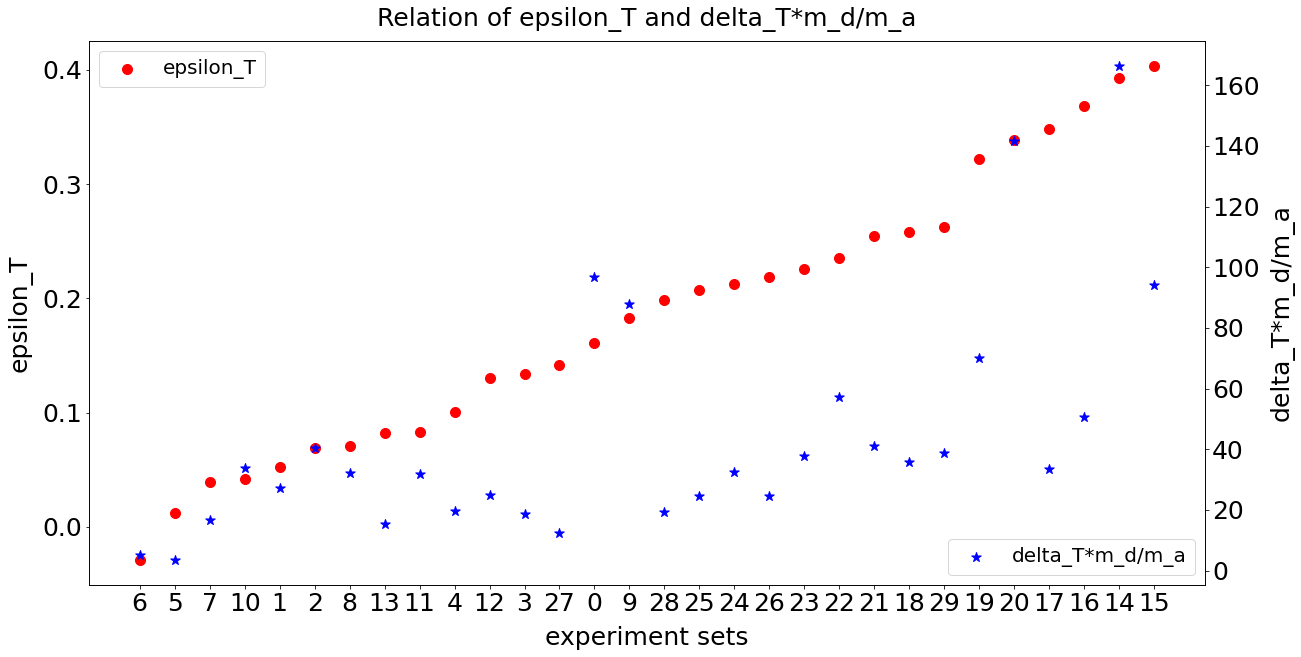

In [156]:
plot_compare_two_parameters(df=df_teststand, \
                            parameter_2="delta_T*m_d/m_a", parameter_1="epsilon_T", \
                           if_save="T_teststand.png")

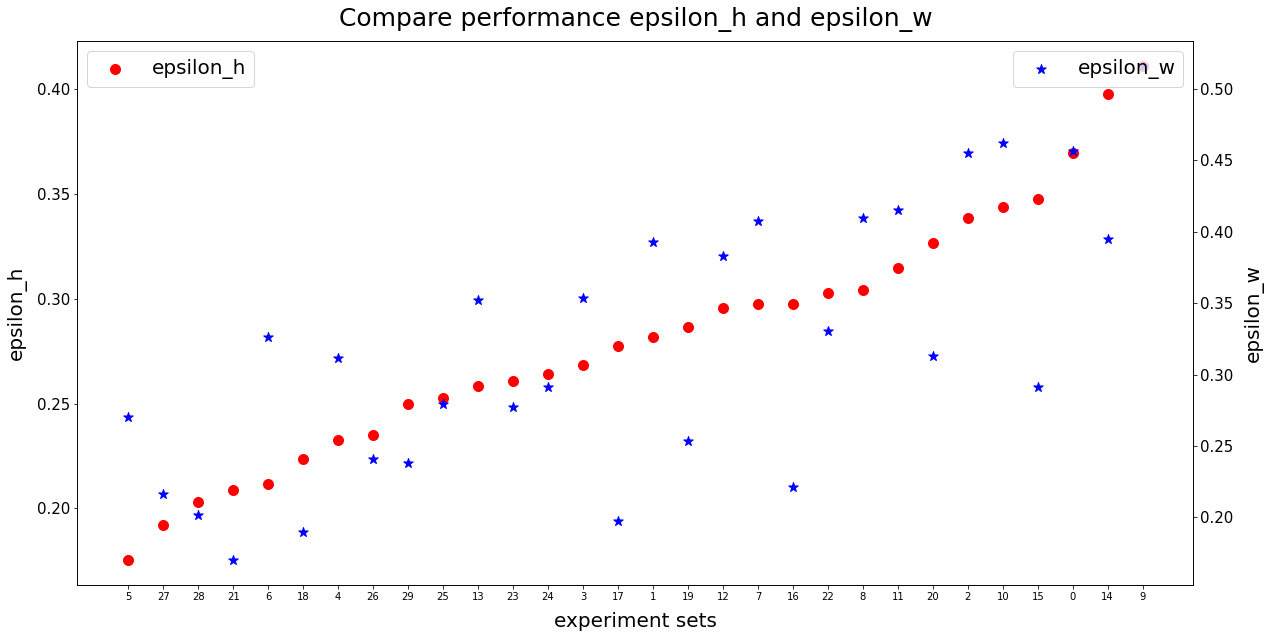

In [60]:
plot_compare_two_parameters(df=df_teststand, \
                            parameter_1="epsilon_h", \
                            parameter_2="epsilon_w",) 

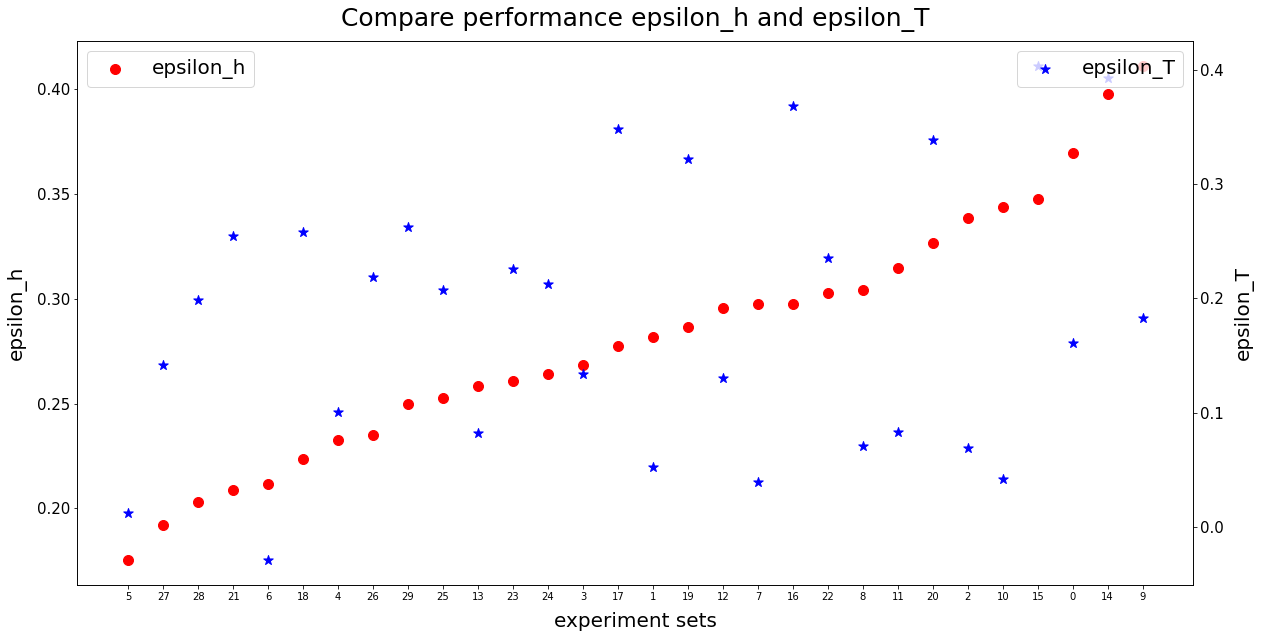

In [61]:
plot_compare_two_parameters(df=df_teststand, \
                            parameter_1="epsilon_h", \
                            parameter_2="epsilon_T",) 

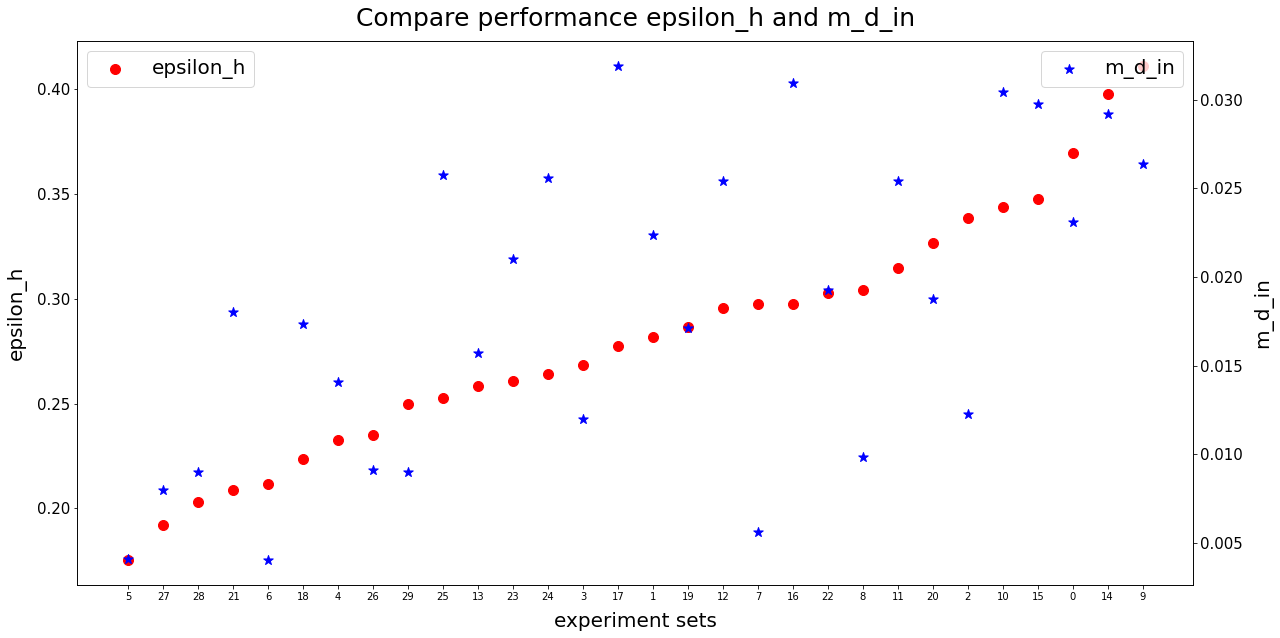

In [62]:
plot_compare_two_parameters(df=df_teststand, \
                            parameter_1="epsilon_h", \
                            parameter_2="m_d_in",) 

# analysis using energy balance

## **ZHAW data**

In [4]:
df_ZHAW = pd.read_excel("../../exp_data/actual_data/ZHAW_data.xlsx", index_col=0)#.drop(columns = ['w_air_in', 'w_air_out'])
df_ZHAW.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp
1,305.65,0.0170,0.27,289.55,0.33,0.62,293.45,0.0063,296.15
2,305.65,0.0170,0.27,290.15,0.33,0.62,294.05,0.0065,296.55
3,305.65,0.0230,0.27,292.65,0.33,0.62,296.25,0.0063,299.15
4,306.65,0.0224,0.27,295.45,0.34,0.63,298.55,0.0086,301.65
5,307.05,0.0233,0.27,297.85,0.34,0.63,300.05,0.0093,303.75


In [5]:
df_ZHAW = prepare_for_h_m(df_ZHAW, if_calc_effectiveness=True)
df_ZHAW.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,hr_air_in,...,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ,delta_T,delta_x,epsilon_T,epsilon_x
1,305.65,0.0170,0.27,289.55,0.33,0.62,293.45,0.0063,296.15,0.548211,...,76219.061714,36407.515359,10749.117516,2.561175,10480.326080,0.004828,16.1,0.012172,0.757764,0.879034
2,305.65,0.0170,0.27,290.15,0.33,0.62,294.05,0.0065,296.55,0.548211,...,76219.061714,37526.002143,10447.126084,2.562190,10166.771758,0.005021,15.5,0.011979,0.748387,0.876537
3,305.65,0.0230,0.27,292.65,0.33,0.62,296.25,0.0063,299.15,0.734798,...,91572.206101,39257.981540,14124.840631,2.566448,10342.785628,0.005904,13.0,0.017096,0.723077,0.976827
4,306.65,0.0224,0.27,295.45,0.34,0.63,298.55,0.0086,301.65,0.677171,...,91086.184133,47457.338566,11779.788303,2.535596,9904.037692,0.006612,11.2,0.015788,0.723214,0.874070
5,307.05,0.0233,0.27,297.85,0.34,0.63,300.05,0.0093,303.75,0.687849,...,93810.958385,50775.757385,11619.504270,2.539895,9440.788757,0.007682,9.2,0.015618,0.760870,0.896415


In [16]:
df_ZHAW.query('(x_d_in_equ < x_a_in) and (T_a_in <= T_d_in)')

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,hr_air_in,...,k,m_da,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ,epsilon_T,epsilon_x
6,297.95,0.0155,0.3,300.65,0.35,0.60,300.25,0.0096,303.45,0.783264,...,0.026288,0.295421,64.404900,51.745471,3.739861,2.510411,4.217490,0.008528,0.851852,0.846227
7,297.65,0.0154,0.3,303.55,0.35,0.63,302.95,0.0108,304.55,0.792422,...,0.026372,0.295450,63.839806,57.577410,1.850226,2.515779,1.584941,0.010159,0.898305,0.877683


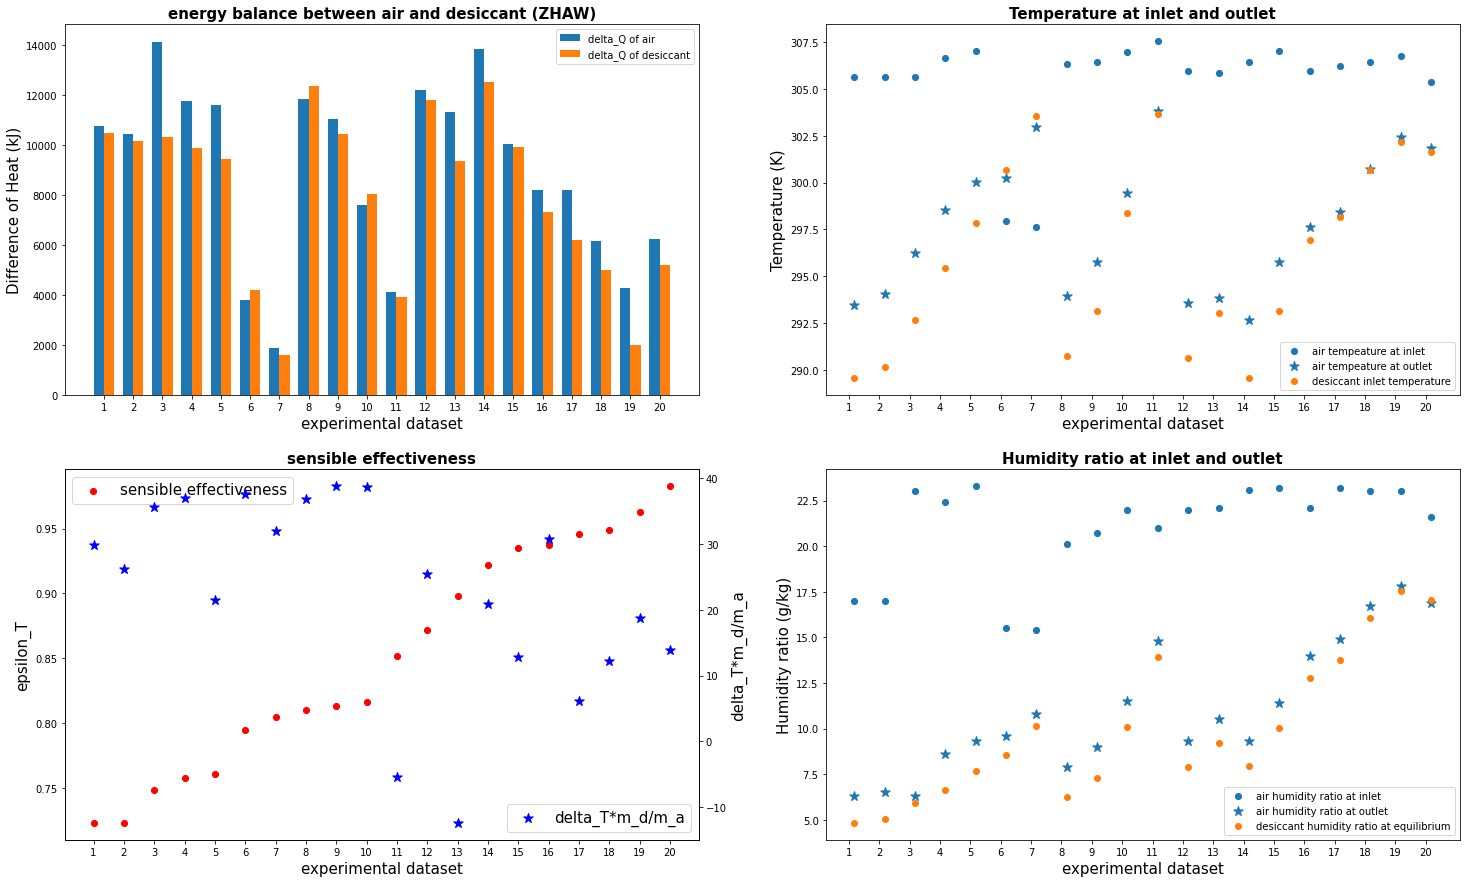

In [6]:
df = df_ZHAW
fig, axs = plt.subplots(2,2, figsize=(25,15))

width = 0.35
x = np.arange(df.shape[0])+1

# energy balance between air and desiccant
axs[0,0].bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
axs[0,0].bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant')

axs[0,0].set_ylabel('Difference of Heat (kJ)', fontsize = 15)
axs[0,0].set_xlabel('experimental dataset', fontsize = 15)
axs[0,0].set_title('energy balance between air and desiccant (ZHAW)', fontsize = 15,  fontweight='bold')
axs[0,0].set_xticks(x)
axs[0,0].legend()

# sensible effectiveness
# temperature of air and desiccant
axs_2 = axs[1,0].twinx()
df_sorted = df.sort_values(by='epsilon_T').reset_index()
axs[1,0].scatter(x, df_sorted.epsilon_T, label='sensible effectiveness', c='red', marker = '.', s = 150)
axs_2.scatter(x, df_sorted.delta_T*df_sorted.m_d_in/df_sorted.m_a_in, label='delta_T*m_d/m_a', c='blue', marker='*',s = 100)

axs[1,0].set_ylabel('epsilon_T', fontsize = 15)
axs_2.set_ylabel('delta_T*m_d/m_a', fontsize = 15)
axs[1,0].set_xlabel('experimental dataset', fontsize = 15)
axs[1,0].set_title('sensible effectiveness', fontsize = 15,  fontweight='bold')
axs[1,0].legend(loc="upper left", fontsize = 15)
axs_2.legend(loc="lower right", fontsize = 15)
axs[1,0].set_xticks(x)

# temperature of air and desiccant
axs[0,1].scatter(x+width/2, df.T_a_in, label='air tempeature at inlet', c='#1f77b4', marker = '.', s = 150)
axs[0,1].scatter(x+width/2, df.T_a_o_exp, label='air tempeature at outlet', c='#1f77b4', marker='*',s = 100)
axs[0,1].scatter(x+width/2, df.T_d_in, label='desiccant inlet temperature', c='#ff7f0e')

axs[0,1].set_ylabel('Temperature (K)', fontsize = 15)
axs[0,1].set_xlabel('experimental dataset', fontsize = 15)
axs[0,1].set_title('Temperature at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[0,1].set_xticks(x)
axs[0,1].legend()

# humidity of air and desiccant (equivalent)
axs[1,1].scatter(x+width/2, df.x_a_in*1000, label='air humidity ratio at inlet', c='#1f77b4', marker = '.', s = 150)
axs[1,1].scatter(x+width/2, df.x_a_o_exp*1000, label='air humidity ratio at outlet', c='#1f77b4', marker='*',s = 100)
axs[1,1].scatter(x+width/2, df.x_d_in_equ*1000, label='desiccant humidity ratio at equilibrium', c='#ff7f0e')

axs[1,1].set_ylabel('Humidity ratio (g/kg)', fontsize = 15)
axs[1,1].set_xlabel('experimental dataset', fontsize = 15)
axs[1,1].set_title('Humidity ratio at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[1,1].set_xticks(x)
axs[1,1].legend()
# plt.show()

# fig.subplots_adjust(wspace= 0, hspace=0)
# plt.savefig('difference_ZHAW.png', dpi=300)

#### energy balance air desiccant

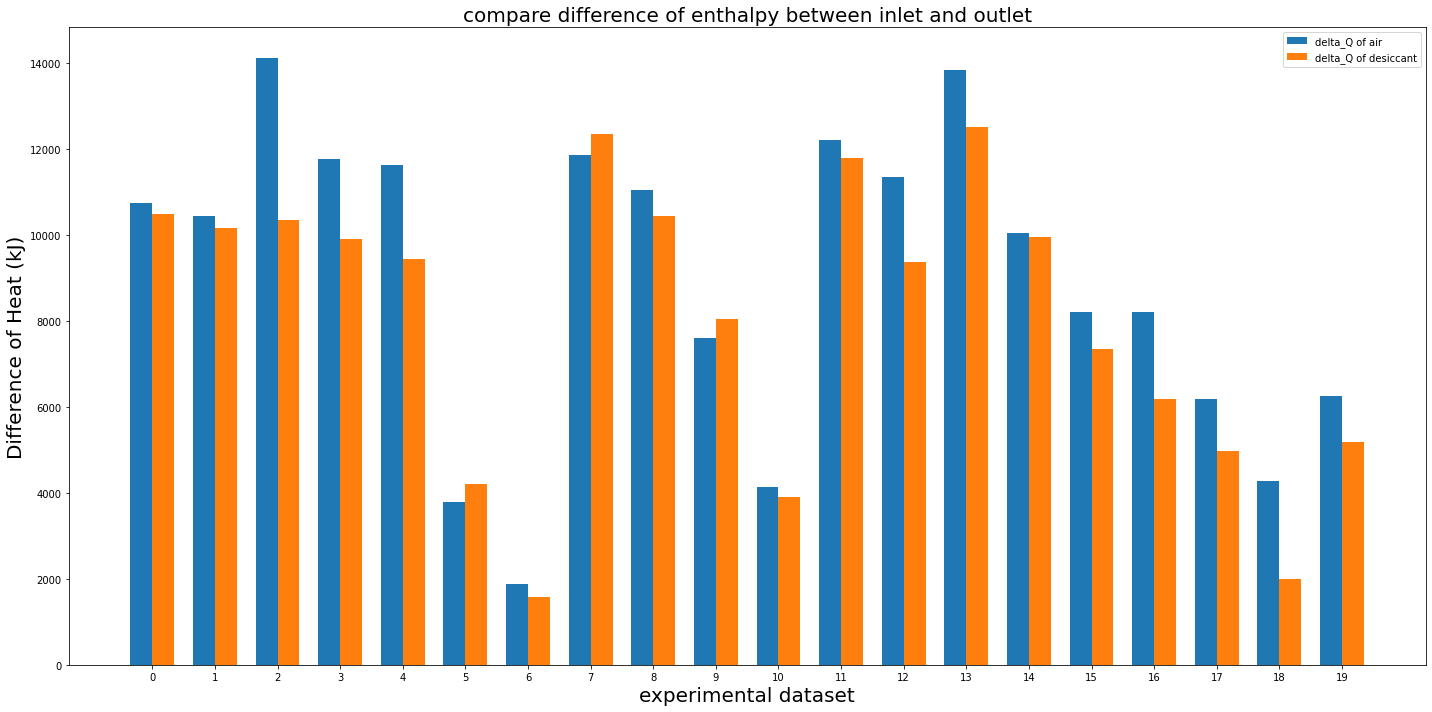

In [7]:
df = df_ZHAW
fig, ax = plt.subplots(figsize=(20,10))

width = 0.35
x = np.arange(df.shape[0])

rects1 = ax.bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
rects2 = ax.bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant')

ax.set_ylabel('Difference of Heat (kJ)', fontsize = 20)
ax.set_xlabel('experimental dataset', fontsize = 20)
ax.set_title('compare difference of enthalpy between inlet and outlet', fontsize = 20)
ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## **Chen (2016)**

In [4]:
df_chen = pd.read_excel("../../exp_data/actual_data/Chen2016.xlsx", index_col=0)#.drop(columns = ['w_air_in', 'w_air_out'])

In [5]:
df_chen = prepare_for_h_m(df_chen, type_des= 'MgCl2',if_calc_effectiveness=True)
df_chen.head()

,T_a_in,x_a_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,x_a_o_exp,T_d_o_exp,xi_d_o_exp,...,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ,delta_T,delta_x,epsilon_T,epsilon_x
1,298.75,0.0162,1.85,288.05,0.230,2.61,292.35,0.0091,294.45,0.2288,...,67015.693517,42385.895500,45565.126332,2.963126,49496.058054,0.007228,10.7,0.008972,0.598131,0.791362
2,301.75,0.0202,1.87,291.35,0.240,2.63,296.05,0.0116,298.35,0.2385,...,80333.113555,52526.376742,51998.597839,2.922638,53805.770886,0.008621,10.4,0.011579,0.548077,0.742717
3,300.65,0.0181,1.92,290.85,0.255,2.65,295.05,0.0099,297.45,0.2535,...,73830.261183,47180.724061,51167.111273,2.858116,49988.440776,0.007838,9.8,0.010262,0.571429,0.799076
4,303.15,0.0177,1.89,292.05,0.260,2.66,296.65,0.0097,298.95,0.2585,...,75410.365921,48311.950676,51216.004813,2.838563,52098.980063,0.008284,11.1,0.009416,0.585586,0.849577
5,300.75,0.0164,1.92,290.45,0.270,2.67,294.75,0.0087,296.85,0.2685,...,69599.718735,43826.026055,49485.489946,2.795256,47765.333983,0.007133,10.3,0.009267,0.582524,0.830934


In [7]:
df_chen.columns

Index(['T_a_in', 'x_a_in', 'm_a_in', 'T_d_in', 'xi_d_in', 'm_d_in',
       'T_a_o_exp', 'x_a_o_exp', 'T_d_o_exp', 'xi_d_o_exp', 'T_d_o_sim',
       'T_a_o_sim', 'x_a_o_sim', 'hr_air_in', 'hr_air_out', 'rho_da', 'rho_ha',
       'k', 'm_da', 'h_a_in', 'h_a_out', 'delta_Q_a', 'cp_d', 'delta_Q_d',
       'x_d_in_equ', 'delta_T', 'delta_x', 'epsilon_T', 'epsilon_x'],
      dtype='object')

In [15]:
df_sorted[['epsilon_T', 'T_a_in', 'T_d_in', 'm_a_in', 'm_d_in', 'x_a_in', 'x_a_o_exp', 'xi_d_in', 'delta_T', 'x_d_in_equ', 'delta_x', 'epsilon_x']]

,epsilon_T,T_a_in,T_d_in,m_a_in,m_d_in,x_a_in,x_a_o_exp,xi_d_in,delta_T,x_d_in_equ,delta_x,epsilon_x
0,0.492537,299.05,292.35,1.99,2.86,0.0159,0.0077,0.3215,6.7,0.006106,0.009794,0.837230
1,0.507692,297.35,290.85,1.98,2.85,0.0160,0.0077,0.3007,6.5,0.006254,0.009746,0.851667
2,0.541667,297.15,289.95,1.94,2.82,0.0152,0.0075,0.2961,7.2,0.006049,0.009151,0.841421
3,0.542857,298.25,291.25,1.94,2.90,0.0152,0.0075,0.3052,7.0,0.006259,0.008941,0.861220
4,0.548077,301.75,291.35,1.87,2.63,0.0202,0.0116,0.2400,10.4,0.008621,0.011579,0.742717
5,0.554054,298.35,290.95,1.95,2.85,0.0143,0.0069,0.3182,7.4,0.005690,0.008610,0.859495
6,0.555556,298.75,291.55,1.93,2.88,0.0143,0.0066,0.3312,7.2,0.005458,0.008842,0.870823
7,0.571429,300.65,290.85,1.92,2.65,0.0181,0.0099,0.2550,9.8,0.007838,0.010262,0.799076
8,0.582524,300.75,290.45,1.92,2.67,0.0164,0.0087,0.2700,10.3,0.007133,0.009267,0.830934
9,0.585586,303.15,292.05,1.89,2.66,0.0177,0.0097,0.2600,11.1,0.008284,0.009416,0.849577


In [10]:
df_sorted.x_a_o_exp / df_sorted.x_d_in_equ

0     1.261096
1     1.231132
2     1.239912
3     1.198238
4     1.345569
5     1.212592
6     1.209281
7     1.263053
8     1.219629
9     1.170996
10    1.261598
11    1.258971
12    1.288974
13    1.405934
14    1.236266
dtype: float64

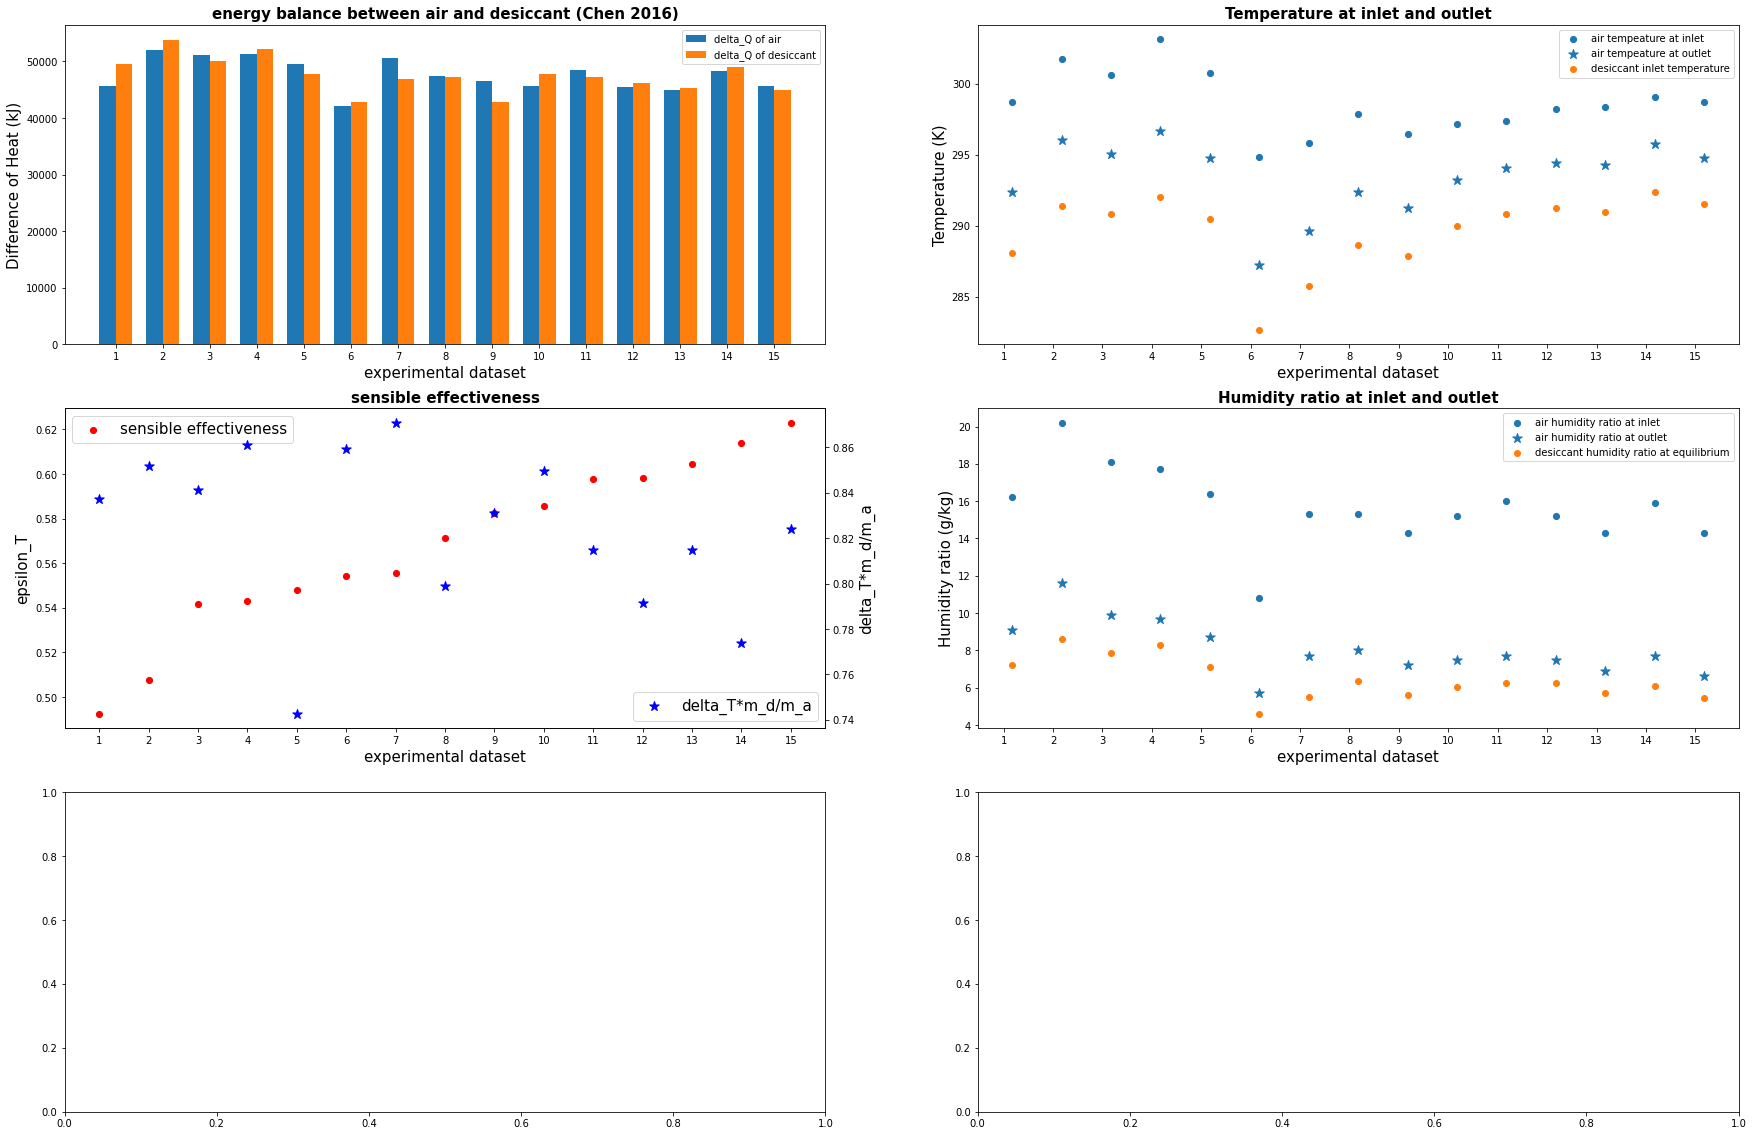

In [14]:
df = df_chen
fig, axs = plt.subplots(3,2, figsize=(30,20))

width = 0.35
x = np.arange(df.shape[0])+1

# energy balance between air and desiccant
axs[0,0].bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
axs[0,0].bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant')

axs[0,0].set_ylabel('Difference of Heat (kJ)', fontsize = 15)
axs[0,0].set_xlabel('experimental dataset', fontsize = 15)
axs[0,0].set_title('energy balance between air and desiccant (Chen 2016)', fontsize = 15,  fontweight='bold')
axs[0,0].set_xticks(x)
axs[0,0].legend()

# sensible effectiveness
# temperature of air and desiccant
axs_2 = axs[1,0].twinx()
df_sorted = df.sort_values(by='epsilon_T').reset_index()
axs[1,0].scatter(x, df_sorted.epsilon_T, label='sensible effectiveness', c='red', marker = '.', s = 150)
axs_2.scatter(x, df_sorted.epsilon_x, label='delta_T*m_d/m_a', c='blue', marker='*',s = 100) #*/df_sorted.m_a_in

#df_sorted.m_d_in * df_sorted.delta_T

axs[1,0].set_ylabel('epsilon_T', fontsize = 15)
axs_2.set_ylabel('delta_T*m_d/m_a', fontsize = 15)
axs[1,0].set_xlabel('experimental dataset', fontsize = 15)
axs[1,0].set_title('sensible effectiveness', fontsize = 15,  fontweight='bold')
axs[1,0].legend(loc="upper left", fontsize = 15)
axs_2.legend(loc="lower right", fontsize = 15)
axs[1,0].set_xticks(x)

# temperature of air and desiccant
axs[0,1].scatter(x+width/2, df.T_a_in, label='air tempeature at inlet', c='#1f77b4', marker = '.', s = 150)
axs[0,1].scatter(x+width/2, df.T_a_o_exp, label='air tempeature at outlet', c='#1f77b4', marker='*',s = 100)
axs[0,1].scatter(x+width/2, df.T_d_in, label='desiccant inlet temperature', c='#ff7f0e')

axs[0,1].set_ylabel('Temperature (K)', fontsize = 15)
axs[0,1].set_xlabel('experimental dataset', fontsize = 15)
axs[0,1].set_title('Temperature at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[0,1].set_xticks(x)
axs[0,1].legend()

# humidity of air and desiccant (equivalent)
axs[1,1].scatter(x+width/2, df.x_a_in*1000, label='air humidity ratio at inlet', c='#1f77b4', marker = '.', s = 150)
axs[1,1].scatter(x+width/2, df.x_a_o_exp*1000, label='air humidity ratio at outlet', c='#1f77b4', marker='*',s = 100)
axs[1,1].scatter(x+width/2, df.x_d_in_equ*1000, label='desiccant humidity ratio at equilibrium', c='#ff7f0e')

axs[1,1].set_ylabel('Humidity ratio (g/kg)', fontsize = 15)
axs[1,1].set_xlabel('experimental dataset', fontsize = 15)
axs[1,1].set_title('Humidity ratio at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[1,1].set_xticks(x)
axs[1,1].legend()
plt.show()

# fig.subplots_adjust(wspace= 0, hspace=0)
# plt.savefig('difference_Chen2016.png', dpi=300)

## **teststand**

In [88]:
df_teststand = pd.read_excel("../exp_data/teststand_output_cool.xlsx", index_col=0) #.drop(columns = ['w_air_in', 'w_air_out'])

In [89]:
df_teststand = prepare_for_h_m(df_teststand)
df_teststand.head()

,T_a_in,hr_air_in,V_a_in,m_a_in,T_d_in,xi_d_in,V_d_in,rho_d_in,m_d_in,T_a_o_exp,...,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ,delta_T,delta_x,epsilon_T,epsilon_x
29,304.36,0.9069,19.15,0.006077,278.89,0.307134,1.08,1284.0,0.023112,300.27,...,99.242213,67.173264,0.189834,2.631320,0.130752,0.002680,25.47,0.023851,0.160581,0.456487
30,298.82,0.8798,47.91,0.015557,279.99,0.301630,1.05,1279.0,0.022382,297.83,...,72.740075,56.290617,0.251270,2.654433,0.183586,0.002989,18.83,0.015431,0.052576,0.392700
33,300.89,0.8928,18.94,0.006098,280.90,0.316120,0.57,1294.0,0.012293,299.50,...,82.000838,59.363853,0.135169,2.599328,0.078286,0.002928,19.99,0.018278,0.069535,0.454925
34,300.63,0.6683,40.55,0.013109,280.34,0.309457,0.56,1287.0,0.012012,297.92,...,67.169441,53.063133,0.182103,2.624235,0.092676,0.002929,20.29,0.012567,0.133563,0.353331
35,301.47,0.6880,47.34,0.015250,280.38,0.304808,0.66,1282.0,0.014102,299.35,...,71.335855,58.201280,0.196999,2.642443,0.138248,0.003017,21.09,0.013771,0.100522,0.311678


In [ ]:
df = df_teststand
fig, axs = plt.subplots(2,2, figsize=(25,15))

width = 0.35
x = np.arange(df.shape[0])+1

# energy balance between air and desiccant
axs[0,0].bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
axs[0,0].bar(x+width/2, df.delta_Q_d, width, label='delta_Q of desiccant')

axs[0,0].set_ylabel('Difference of Heat (kJ)', fontsize = 15)
axs[0,0].set_xlabel('experimental dataset', fontsize = 15)
axs[0,0].set_title('energy balance between air and desiccant (TUB teststand)', fontsize = 15,  fontweight='bold')
axs[0,0].set_xticks(x)
axs[0,0].legend()

# sensible effectiveness
# temperature of air and desiccant
axs_2 = axs[1,0].twinx()
df_sorted = df.sort_values(by='epsilon_T').reset_index()
axs[1,0].scatter(x, df_sorted.epsilon_T, label='sensible effectiveness', c='red', marker = '.', s = 150)
axs_2.scatter(x, df_sorted.delta_T*df_sorted.m_d_in/df_sorted.m_a_in, label='delta_T*m_d/m_a', c='blue', marker='*',s = 100)

axs[1,0].set_ylabel('epsilon_T', fontsize = 15)
axs_2.set_ylabel('delta_T*m_d/m_a', fontsize = 15)
axs[1,0].set_xlabel('experimental dataset', fontsize = 15)
axs[1,0].set_title('sensible effectiveness', fontsize = 15,  fontweight='bold')
axs[1,0].legend(loc="upper left", fontsize = 15)
axs_2.legend(loc="lower right", fontsize = 15)
axs[1,0].set_xticks(x)

# temperature of air and desiccant
axs[0,1].scatter(x+width/2, df.T_a_in, label='air tempeature at inlet', c='#1f77b4', marker = '.', s = 150)
axs[0,1].scatter(x+width/2, df.T_a_o_exp, label='air tempeature at outlet', c='#1f77b4', marker='*',s = 100)
axs[0,1].scatter(x+width/2, df.T_d_in, label='desiccant inlet temperature', c='#ff7f0e')

axs[0,1].set_ylabel('Temperature (K)', fontsize = 15)
axs[0,1].set_xlabel('experimental dataset', fontsize = 15)
axs[0,1].set_title('Temperature at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[0,1].set_xticks(x)
axs[0,1].legend()

# humidity of air and desiccant (equivalent)
axs[1,1].scatter(x+width/2, df.x_a_in*1000, label='air humidity ratio at inlet', c='#1f77b4', marker = '.', s = 150)
axs[1,1].scatter(x+width/2, df.x_a_o_exp*1000, label='air humidity ratio at outlet', c='#1f77b4', marker='*',s = 100)
axs[1,1].scatter(x+width/2, df.x_d_in_equ*1000, label='desiccant humidity ratio at equilibrium', c='#ff7f0e')

axs[1,1].set_ylabel('Humidity ratio (g/kg)', fontsize = 15)
axs[1,1].set_xlabel('experimental dataset', fontsize = 15)
axs[1,1].set_title('Humidity ratio at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[1,1].set_xticks(x)
axs[1,1].legend()
# plt.show()

# fig.subplots_adjust(wspace= 0, hspace=0)
plt.savefig('difference_teststand.png', dpi=300)

## **DemPav**

In [22]:
df_dempav = pd.read_excel("../exp_data/dempav_results_Aug_final_2020.xlsx", index_col=0) #.drop(columns = ['w_air_in', 'w_air_out'])

In [23]:
df_dempav = prepare_for_h_m(df_dempav)
df_dempav.head()

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,...,rho_da,rho_ha,k,m_da,h_a_in,h_a_out,delta_Q_a,cp_d,delta_Q_d,x_d_in_equ
0,298.02,0.480462,0.018848,287.44,0.318302,0.102670,290.21,0.476947,286.230,0.009457,...,1.167162,1.178200,0.025937,0.018848,49097.449796,31774.623096,326.495736,2.601039,-323.130317,0.004515
1,300.51,0.553303,0.036283,292.20,0.318186,0.102670,294.81,0.538242,290.092,0.012683,...,1.151599,1.166205,0.026193,0.036283,59874.298508,43928.255277,578.564508,2.609102,-564.681931,0.006170
2,298.02,0.458659,0.032644,284.16,0.318572,0.102670,287.98,0.506137,281.766,0.009022,...,1.167964,1.178501,0.025856,0.032644,47989.141388,28332.594775,641.676835,2.594899,-637.808331,0.003614
3,301.31,0.504712,0.036150,290.94,0.318174,0.102669,293.69,0.519635,288.468,0.012112,...,1.149564,1.163488,0.026183,0.036150,59240.808747,40570.888880,674.917727,2.607111,-661.678132,0.005687
4,299.87,0.423994,0.045742,290.34,0.318171,0.102668,292.89,0.525218,288.366,0.009311,...,1.160209,1.171011,0.026104,0.045742,50619.147152,38987.326200,532.063750,2.606157,-528.181465,0.005470


In [ ]:
df = df_dempav
fig, axs = plt.subplots(3,2, figsize=(25,15))

width = 0.35
x = np.arange(df.shape[0])+1

# energy balance between air and desiccant
axs[0,0].bar(x-width/2, df.delta_Q_a, width, label='delta_Q of air')
axs[0,0].bar(x+width/2, -df.delta_Q_d, width, label='delta_Q of desiccant')

axs[0,0].set_ylabel('Difference of Heat (kJ)', fontsize = 15)
axs[0,0].set_xlabel('experimental dataset', fontsize = 15)
axs[0,0].set_title('energy balance between air and desiccant (TUB DemPav)', fontsize = 15,  fontweight='bold')
axs[0,0].set_xticks(x)
axs[0,0].legend()

# sensible effectiveness
# temperature of air and desiccant
axs_2 = axs[1,0].twinx()
df_sorted = df.sort_values(by='epsilon_T').reset_index()
axs[1,0].scatter(x, df_sorted.epsilon_T, label='sensible effectiveness', c='red', marker = '.', s = 150)
axs_2.scatter(x, df_sorted.delta_T*df_sorted.m_d_in/df_sorted.m_a_in, label='delta_T*m_d/m_a', c='blue', marker='*',s = 100)

axs[1,0].set_ylabel('epsilon_T', fontsize = 15)
axs_2.set_ylabel('delta_T*m_d/m_a', fontsize = 15)
axs[1,0].set_xlabel('experimental dataset', fontsize = 15)
axs[1,0].set_title('sensible effectiveness', fontsize = 15,  fontweight='bold')
axs[1,0].legend(loc="upper left", fontsize = 15)
axs_2.legend(loc="lower right", fontsize = 15)
axs[1,0].set_xticks(x)

# temperature of air and desiccant
axs[0,1].scatter(x+width/2, df.T_a_in, label='air tempeature at inlet', c='#1f77b4', marker = '.', s = 150)
axs[0,1].scatter(x+width/2, df.T_a_o_exp, label='air tempeature at outlet', c='#1f77b4', marker='*',s = 100)
axs[0,1].scatter(x+width/2, df.T_d_in, label='desiccant inlet temperature', c='#ff7f0e')

axs[0,1].set_ylabel('Temperature (K)', fontsize = 15)
axs[0,1].set_xlabel('experimental dataset', fontsize = 15)
axs[0,1].set_title('Temperature at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[0,1].set_xticks(x)
axs[0,1].legend()

# humidity of air and desiccant (equivalent)
axs[1,1].scatter(x+width/2, df.x_a_in*1000, label='air humidity ratio at inlet', c='#1f77b4', marker = '.', s = 150)
axs[1,1].scatter(x+width/2, df.x_a_o_exp*1000, label='air humidity ratio at outlet', c='#1f77b4', marker='*',s = 100)
axs[1,1].scatter(x+width/2, df.x_d_in_equ*1000, label='desiccant humidity ratio at equilibrium', c='#ff7f0e')

axs[1,1].set_ylabel('Humidity ratio (g/kg)', fontsize = 15)
axs[1,1].set_xlabel('experimental dataset', fontsize = 15)
axs[1,1].set_title('Humidity ratio at inlet and outlet', fontsize = 15,  fontweight='bold')
axs[1,1].set_xticks(x)
axs[1,1].legend()
# plt.show()

# fig.subplots_adjust(wspace= 0, hspace=0)
plt.savefig('difference_DemPav.png', dpi=300)